In [1]:
!pip install seaborn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

# image libraries
import cv2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
train_img_path = '/kaggle/input/aidata/train'
test_img_path = '/kaggle/input/aidata/val'

w,h = 224,224
batch_size = 32

train_data_gen = ImageDataGenerator(
    rescale=1.0/255,
)
test_data_gen = ImageDataGenerator(rescale = 1.0/255)

train_Dataset = train_data_gen.flow_from_directory(
    train_img_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = True
)

test_Dataset = test_data_gen.flow_from_directory(
    test_img_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = False
)

Found 18557 images belonging to 2 classes.
Found 61 images belonging to 2 classes.


In [7]:
test_Dataset.class_indices


{'0': 0, '1': 1}

In [8]:
test_Dataset.image_shape

(224, 224, 3)

In [9]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.OneDeviceStrategy("GPU:0")  # Default strategy for non-TPU environments


In [10]:
# Load the MobileNetV2 model with pre-trained weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # Use a valid input shape

# Create a new model by adding your custom top layers for binary classification
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

# Freeze the weights of the MobileNetV2 layers (optional)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 22,327,585
Trainable params: 524,801
Non-tr

In [11]:
# Save best model
weight_path = '/kaggle/working/'

model_checkpoint = ModelCheckpoint(
    filepath = weight_path,
    save_best_only = True,
    save_weights_only = True,
    mode = 'max',
    monitor = 'val_accuracy'
)


In [12]:

num_folds = 3  # You can adjust this value based on your requirements

# Create a K-fold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lists to store the training and validation scores
train_scores = []
val_scores = []

# Convert the ImageDataGenerator to NumPy arrays
train_data = train_Dataset[0][0]
train_labels = train_Dataset[0][1]

for i in range(1, len(train_Dataset)):
    train_data = np.vstack((train_data, train_Dataset[i][0]))
    train_labels = np.hstack((train_labels, train_Dataset[i][1]))

for train_index, val_index in kf.split(train_data):
    train_subset_data = train_data[train_index]
    train_subset_labels = train_labels[train_index]
    val_subset_data = train_data[val_index]
    val_subset_labels = train_labels[val_index]

    # Create a new model for each fold (if needed) or reset the existing model

    # Fit the model to the current training fold
    history = model.fit(train_subset_data,
                        train_subset_labels,
                        epochs=8,
                        validation_data=(val_subset_data, val_subset_labels),
                        callbacks=[model_checkpoint]
                       )
    
    # Record the training and validation scores for this fold
    train_scores.append(history.history['accuracy'])
    val_scores.append(history.history['val_accuracy'])

# Calculate and report the average and standard deviation of the validation scores
average_val_score = np.mean(val_scores)
std_val_score = np.std(val_scores)

print("Average Validation Accuracy:", average_val_score)
print("Standard Deviation of Validation Accuracy:", std_val_score)


KeyboardInterrupt: 

In [ ]:
fig, axes = plt.subplots(num_folds, 1, figsize=(8, 12), sharex=True, sharey=True)

for i in range(num_folds):
    axes[i].plot(history.epoch, train_scores[i], label=f'Training Fold {i}')
    axes[i].plot(history.epoch, val_scores[i], label=f'Validation Fold {i}')
    axes[i].set_ylabel('Accuracy')
    axes[i].legend()

# Set common labels and title
axes[-1].set_xlabel('Epochs')
fig.suptitle('Training and Validation Scores for Each Fold', y=1.02)

plt.show()

In [ ]:
# load best weights to model
#model.load_weights(weight_path)

# make prediction
predictions = model.predict(test_Dataset)

In [ ]:
binary_predictions = (predictions > 0.5).astype(int)
binary_predictions

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have true labels (ground truth)
true_labels = test_Dataset.classes

# Generate a confusion matrix
sns.heatmap(confusion_matrix(true_labels, binary_predictions), annot=True)

# Print classification report
print(classification_report(true_labels, binary_predictions))

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual Classes')
plt.show()

In [ ]:
model.save('gnet.h5')

# Second Model :

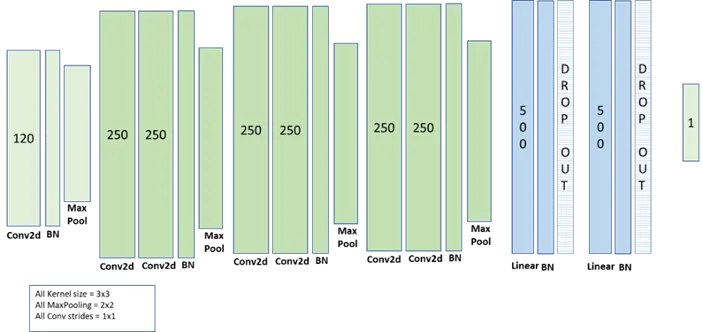


In [20]:
batch_size = 48
img_height = 150
img_width = 150

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_img_path,
    label_mode="binary",
    #label_mode="categorical",
    seed=123,
    validation_split=0.2,
    subset="training",
    image_size=(img_height, img_width),
    batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_img_path,
    label_mode="binary",
    #label_mode="categorical",
    seed=123,
    validation_split=0.2,
    subset="validation",
    image_size=(img_height, img_width),
    batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_img_path,
  label_mode="binary",
  #label_mode="categorical",
  seed=321,
  image_size=(img_height, img_width),
  batch_size=batch_size)


class_names = train_ds.class_names
print(class_names)

Found 18557 files belonging to 2 classes.
Using 14846 files for training.
Found 18557 files belonging to 2 classes.
Using 3711 files for validation.
Found 61 files belonging to 2 classes.
['0', '1']


In [21]:
from tensorflow import keras
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    #layers.RandomRotation(0.01),
    layers.RandomZoom(0.1),
  ])
rescale = tf.keras.Sequential([
  layers.Rescaling(1./255)
])

In [22]:
from tensorflow.keras import Sequential

model2 = Sequential([
  data_augmentation,
  rescale,
  layers.Conv2D(120, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(250, 3, padding='same', activation='relu'),
  layers.Conv2D(250, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(250, 3, padding='same', activation='relu'),
  layers.Conv2D(250, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(250, 3, padding='same', activation='relu'),
  layers.Conv2D(250, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(500, activation='relu'),
  layers.BatchNormalization(),
  layers.Dropout(0.2),
  layers.Dense(500, activation='relu'),
  layers.BatchNormalization(),
  layers.Dropout(0.2),
  layers.Dense(1, activation='sigmoid')
])
opt = keras.optimizers.Adam(learning_rate=0.0001)
model2.compile(opt,
              #loss=tf.keras.losses.BinaryCrossentropy(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

#callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)
check_point = tf.keras.callbacks.ModelCheckpoint('model_{}.h5'.format('12'),
                                                 monitor='accuracy',
                                                 save_best_only=True)

model2.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 sequential_5 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 conv2d_101 (Conv2D)         (None, 150, 150, 120)     3360      
                                                                 
 batch_normalization_100 (Ba  (None, 150, 150, 120)    480       
 tchNormalization)                                               
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 75, 75, 120)      0         
 2D)                                                             
                                                                 
 conv2d_102 (Conv2D)         (None, 75, 75, 250)      

In [23]:
epochs = 20
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stop, check_point]#, callback]
)

Epoch 1/20
310/310 [==============================] - 130s 397ms/step - loss: 0.4465 - accuracy: 0.8065 - val_loss: 1.1951 - val_accuracy: 0.4546
Epoch 2/20
310/310 [==============================] - 122s 394ms/step - loss: 0.3382 - accuracy: 0.8565 - val_loss: 0.2771 - val_accuracy: 0.8817
Epoch 3/20
310/310 [==============================] - 123s 394ms/step - loss: 0.2903 - accuracy: 0.8786 - val_loss: 0.2805 - val_accuracy: 0.8828
Epoch 4/20
310/310 [==============================] - 123s 395ms/step - loss: 0.2654 - accuracy: 0.8908 - val_loss: 0.2460 - val_accuracy: 0.8971
Epoch 5/20
310/310 [==============================] - 123s 395ms/step - loss: 0.2405 - accuracy: 0.8998 - val_loss: 0.2152 - val_accuracy: 0.9111
Epoch 6/20
310/310 [==============================] - 124s 398ms/step - loss: 0.2208 - accuracy: 0.9079 - val_loss: 0.2188 - val_accuracy: 0.9108
Epoch 7/20
310/310 [==============================] - 123s 395ms/step - loss: 0.1953 - accuracy: 0.9200 - val_loss: 0.2017 -

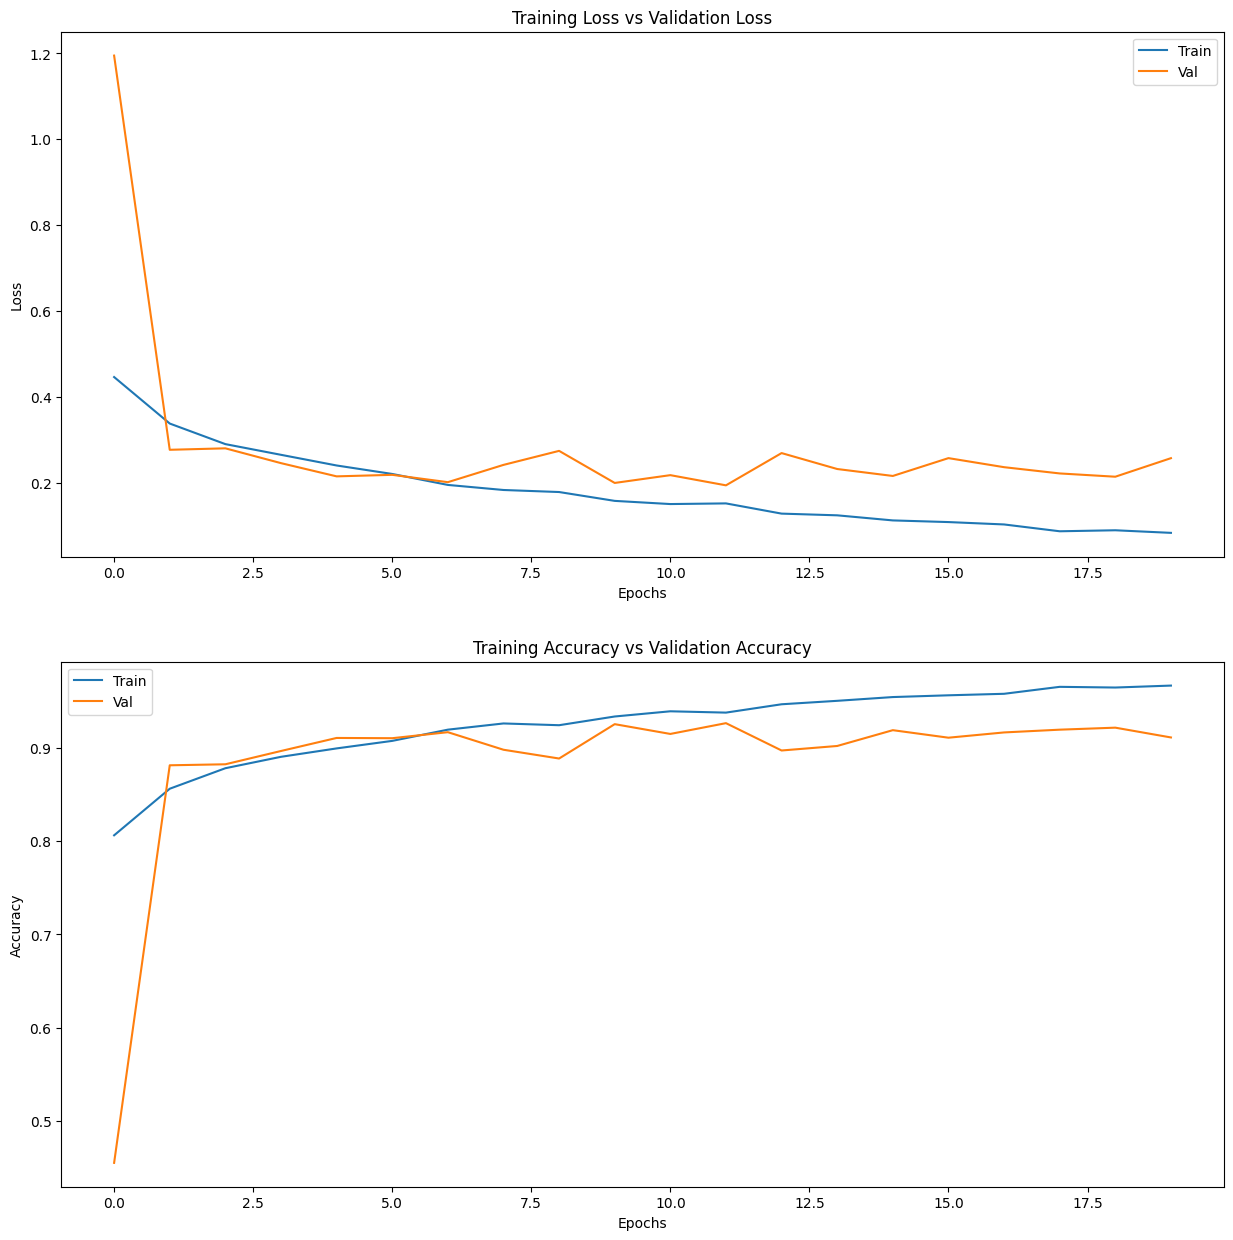

In [24]:
fig, axs = plt.subplots(2, 1, figsize=(15, 15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

plt.show()

In [25]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Assuming you have your test data generator named test_ds
# and class_labels is a list of your class labels

# Function to calculate precision, recall, f1-score, and accuracy
def calculate_metrics(model, test_ds, class_labels):
    y_pred = model.predict(test_ds)
    y_true = test_ds.classes
    accuracy = accuracy_score(y_true, np.argmax(y_pred, axis=1))
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, np.argmax(y_pred, axis=1), average='weighted')
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }
    return metrics

# Calculate metrics for each model
metrics_model = calculate_metrics(model, test_ds, class_names)
metrics_model2 = calculate_metrics(model2, test_ds, class_names)

# Create a DataFrame
df = pd.DataFrame([metrics_model, metrics_model2], index=['Inceptionv3', 'CNN scratch'])

# Display the DataFrame
print(df)

ValueError: in user code:

    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 150, 150, 3)
